In [384]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.impute import KNNImputer

import random

random.seed(42)

In [385]:
df = pd.read_csv('train.csv', index_col='id')

df.head()

,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
id,,,,,,,,,,,,,,,,,,,,
0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,Premium,2.0,17.0,372.0,5.0,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.0
1,39.0,Female,31678.0,Divorced,3.0,Master's,NaN,15.569731,Rural,Comprehensive,1.0,12.0,694.0,2.0,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.0
2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,Premium,1.0,14.0,NaN,3.0,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.0
3,21.0,Male,141855.0,Married,2.0,Bachelor's,NaN,10.938144,Rural,Basic,1.0,0.0,367.0,1.0,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.0
4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,Premium,0.0,8.0,598.0,4.0,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,2022.0


In [386]:
df.columns = df.columns.str.replace(' ', '_').str.lower()

In [387]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1200000 entries, 0 to 1199999
Data columns (total 20 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   age                   1181295 non-null  float64
 1   gender                1200000 non-null  object 
 2   annual_income         1155051 non-null  float64
 3   marital_status        1181471 non-null  object 
 4   number_of_dependents  1090328 non-null  float64
 5   education_level       1200000 non-null  object 
 6   occupation            841925 non-null   object 
 7   health_score          1125924 non-null  float64
 8   location              1200000 non-null  object 
 9   policy_type           1200000 non-null  object 
 10  previous_claims       835971 non-null   float64
 11  vehicle_age           1199994 non-null  float64
 12  credit_score          1062118 non-null  float64
 13  insurance_duration    1199999 non-null  float64
 14  policy_start_date     1200000 non-null 

In [388]:
df['policy_start_date'] = pd.to_datetime(df['policy_start_date'])   #Преобразуем в формат даты
df['year'] = df['policy_start_date'].dt.year #Создаем числовую колонку с годом и месяцем
df['month'] = df['policy_start_date'].dt.month 


In [389]:
df_num = df.select_dtypes(include=np.number)
df_num.describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])

,age,annual_income,number_of_dependents,health_score,previous_claims,vehicle_age,credit_score,insurance_duration,premium_amount,year,month
count,1.181295e+06,1.155051e+06,1.090328e+06,1.125924e+06,835971.000000,1.199994e+06,1.062118e+06,1.199999e+06,1.200000e+06,1.200000e+06,1.200000e+06
mean,4.114556e+01,3.274522e+04,2.009934e+00,2.561391e+01,1.002689,9.569889e+00,5.929244e+02,5.018219e+00,1.102545e+03,2.021621e+03,6.492671e+00
std,1.353995e+01,3.217951e+04,1.417338e+00,1.220346e+01,0.982840,5.776189e+00,1.499819e+02,2.594331e+00,8.649989e+02,1.476008e+00,3.432689e+00
min,1.800000e+01,1.000000e+00,0.000000e+00,2.012237e+00,0.000000,0.000000e+00,3.000000e+02,1.000000e+00,2.000000e+01,2.019000e+03,1.000000e+00
10%,2.200000e+01,2.627000e+03,0.000000e+00,9.936849e+00,0.000000,2.000000e+00,3.830000e+02,1.000000e+00,1.500000e+02,2.020000e+03,2.000000e+00
25%,3.000000e+01,8.001000e+03,1.000000e+00,1.591896e+01,0.000000,5.000000e+00,4.680000e+02,3.000000e+00,5.140000e+02,2.020000e+03,4.000000e+00
50%,4.100000e+01,2.391100e+04,2.000000e+00,2.457865e+01,1.000000,1.000000e+01,5.950000e+02,5.000000e+00,8.720000e+02,2.022000e+03,6.000000e+00
75%,5.300000e+01,4.463400e+04,3.000000e+00,3.452721e+01,2.000000,1.500000e+01,7.210000e+02,7.000000e+00,1.509000e+03,2.023000e+03,9.000000e+00
90%,6.000000e+01,8.107500e+04,4.000000e+00,4.328134e+01,2.000000,1.800000e+01,7.920000e+02,9.000000e+00,2.363000e+03,2.024000e+03,1.100000e+01
max,6.400000e+01,1.499970e+05,4.000000e+00,5.897591e+01,9.000000,1.900000e+01,8.490000e+02,9.000000e+00,4.999000e+03,2.024000e+03,1.200000e+01


In [390]:
print('Пропуски: ', df_num.isna().sum())

Пропуски:  age                      18705
annual_income            44949
number_of_dependents    109672
health_score             74076
previous_claims         364029
vehicle_age                  6
credit_score            137882
insurance_duration           1
premium_amount               0
year                         0
month                        0
dtype: int64


In [ ]:
df_num = df.select_dtypes(include=np.number)

features = list(df_num.columns)
fig, axes = plt.subplots(5, len(features) // 5 + 1, figsize=(32, 16))

for idx, col in enumerate(features):
    sns.kdeplot(data=df_num, x=col, ax=axes[idx % 5, idx // 5])

In [392]:
df['annual_income'] = np.log1p(df['annual_income']) #Логарифмируем чтобы приблизить к нормальному распределению

<Axes: >

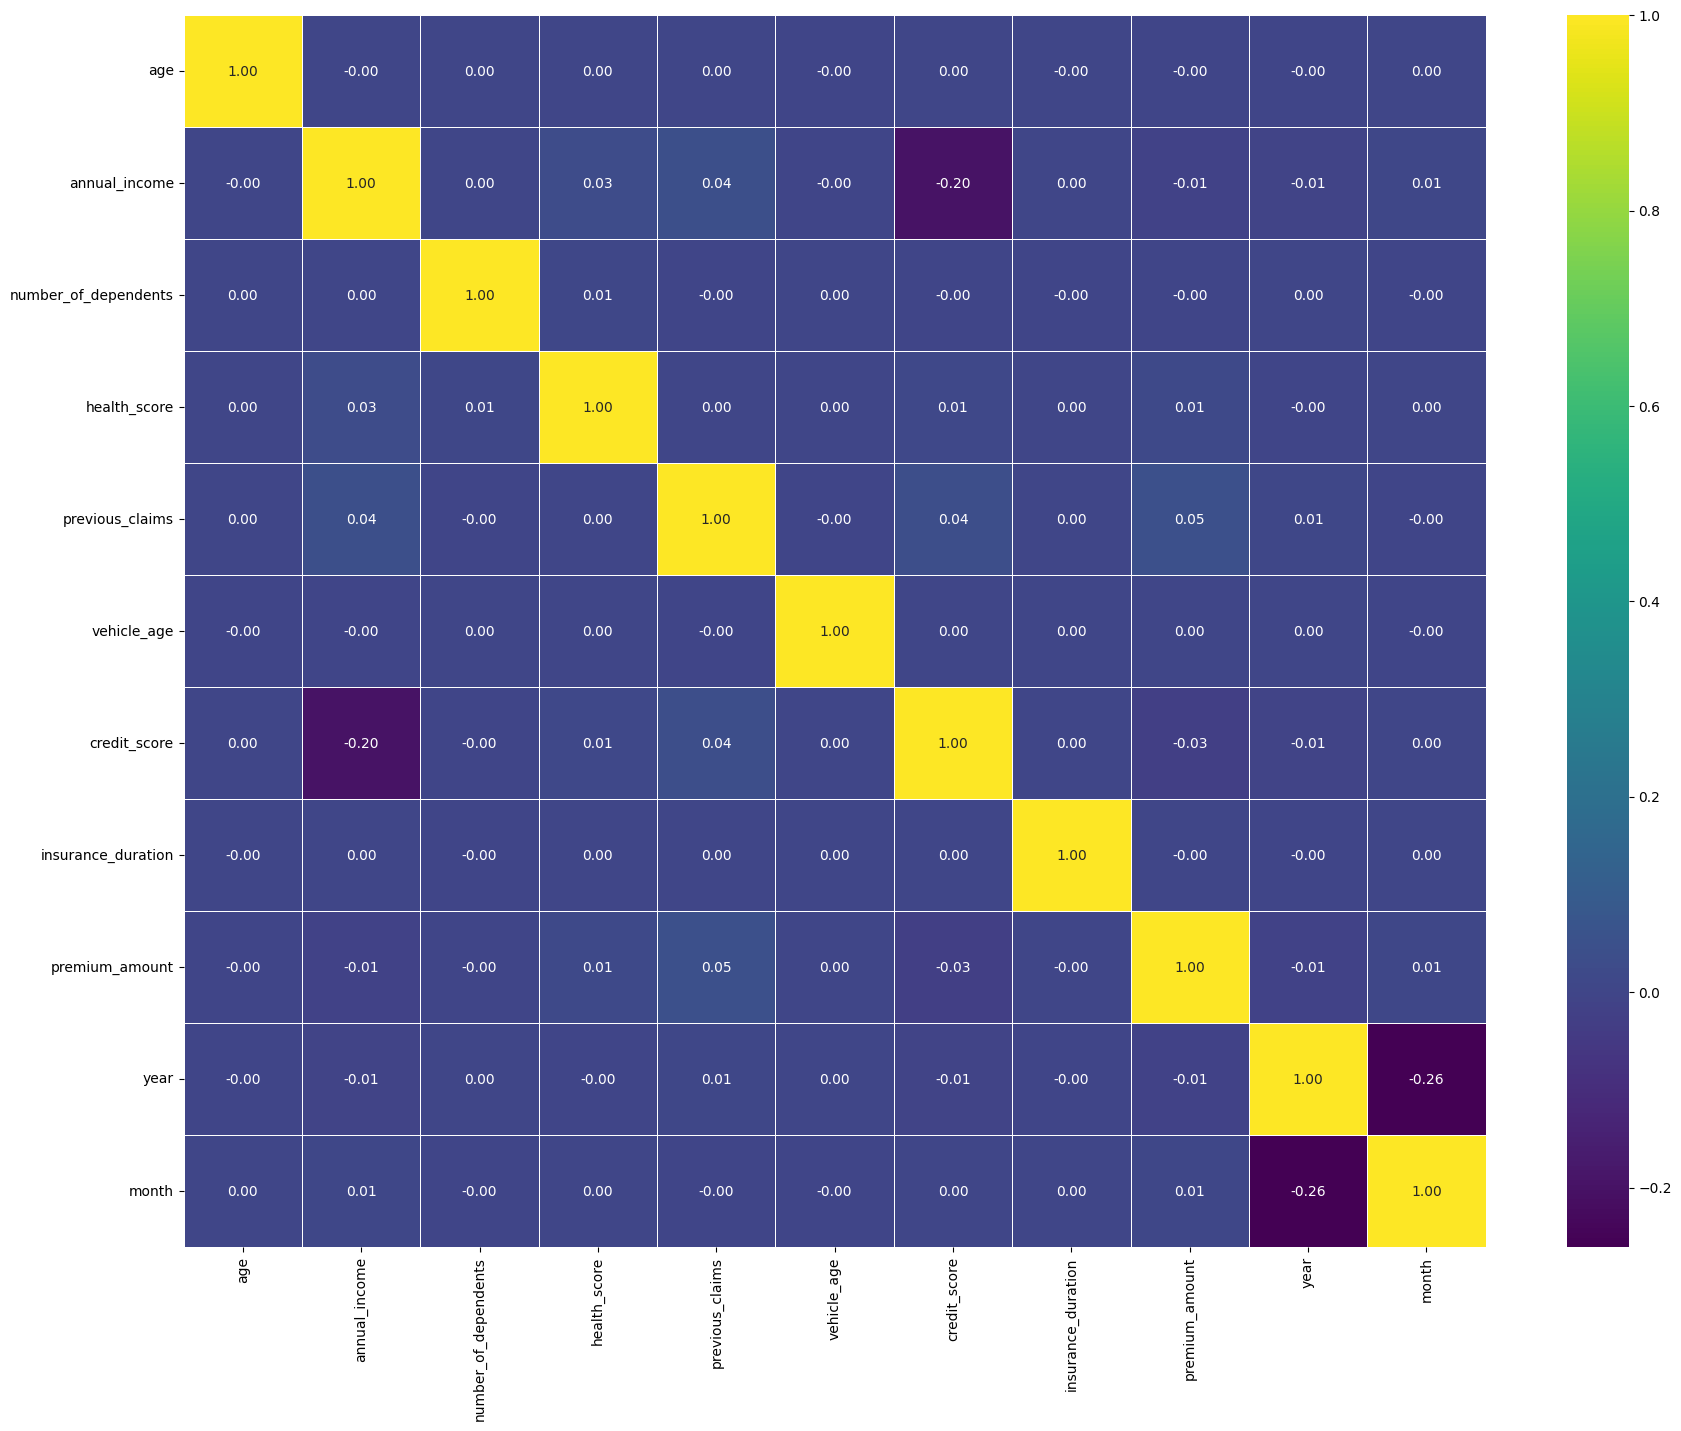

In [393]:
#Корреляция признаков между собой
plt.figure(figsize=(21, 16))
correlation_matrix = df_num.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt='.2f', linewidths=0.5)

In [394]:
#Преобразуем в категориальные фичи
categorial = df.select_dtypes(include=np.object_).columns.to_list()

for col in categorial:
    df[col] = pd.Categorical(df[col])

df[categorial].isna().sum()


gender                     0
marital_status         18529
education_level            0
occupation            358075
location                   0
policy_type                0
customer_feedback      77824
smoking_status             0
exercise_frequency         0
property_type              0
dtype: int64

In [395]:
#Посмотрим какие категори бывают
categorical = df.select_dtypes(include=['category']).columns.tolist()

cat_unique = {var: df[var].dropna().unique().tolist() for var in categorical}
cat_unique


{'gender': ['Female', 'Male'],
 'marital_status': ['Married', 'Divorced', 'Single'],
 'education_level': ["Bachelor's", "Master's", 'High School', 'PhD'],
 'occupation': ['Self-Employed', 'Employed', 'Unemployed'],
 'location': ['Urban', 'Rural', 'Suburban'],
 'policy_type': ['Premium', 'Comprehensive', 'Basic'],
 'customer_feedback': ['Poor', 'Average', 'Good'],
 'smoking_status': ['No', 'Yes'],
 'exercise_frequency': ['Weekly', 'Monthly', 'Daily', 'Rarely'],
 'property_type': ['House', 'Apartment', 'Condo']}

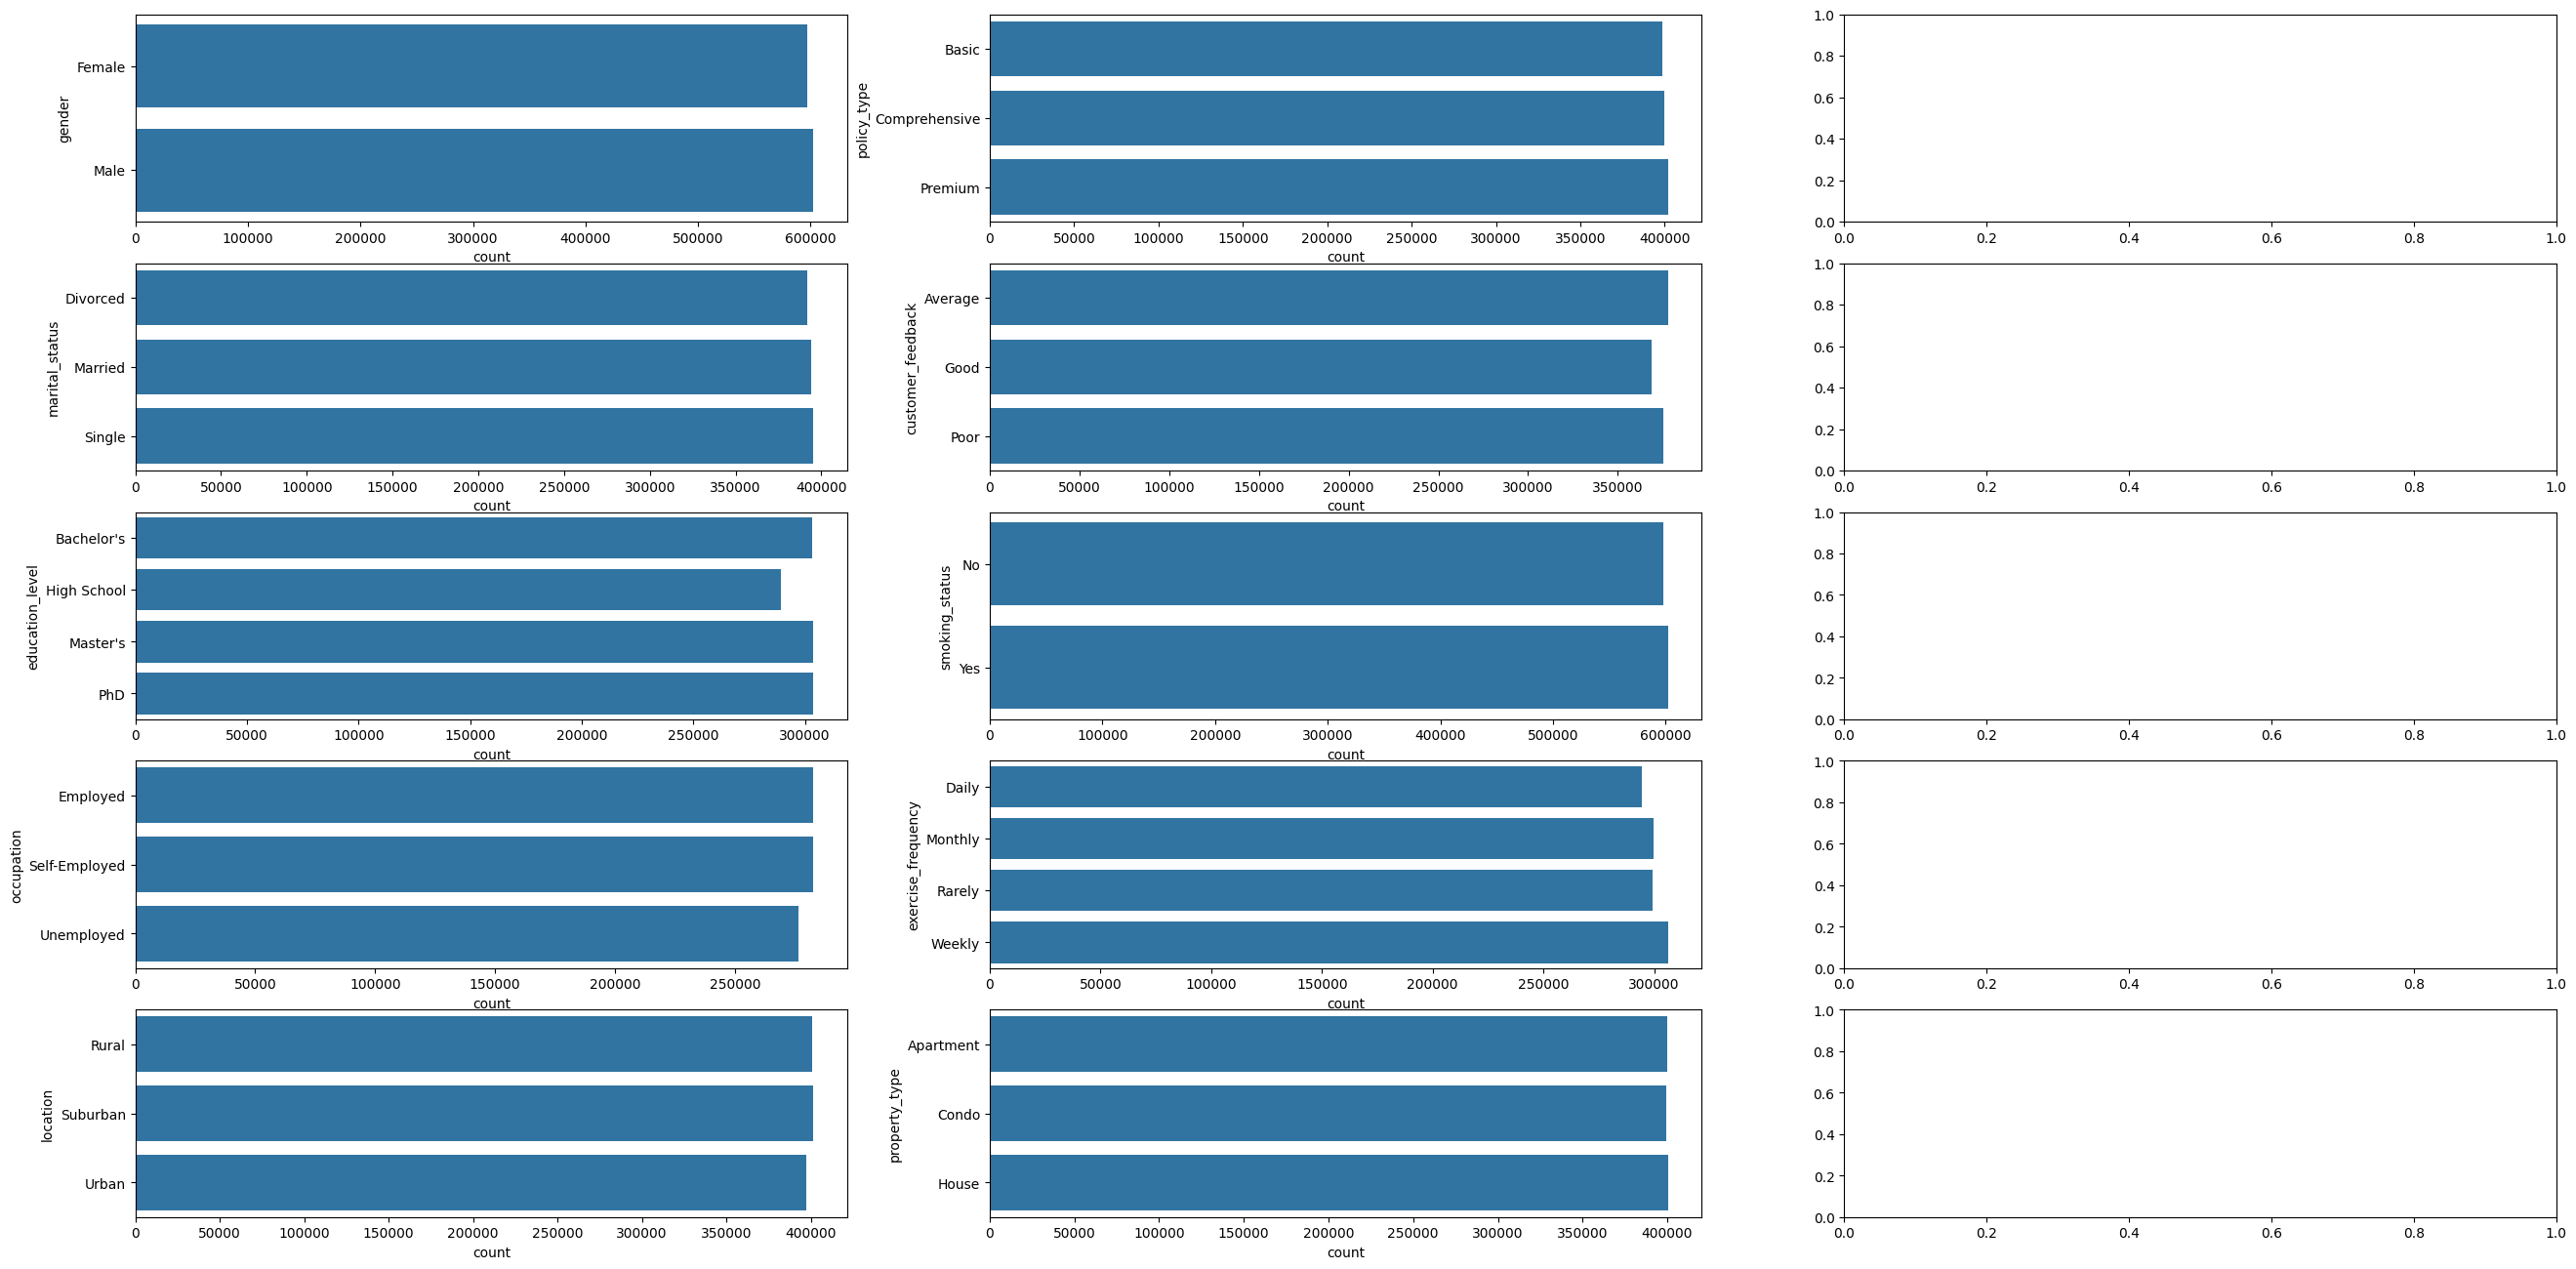

In [396]:
#Построим распределение категориальных признаков
fig, axes = plt.subplots(5, len(categorial) // 5 + 1, figsize=(32, 16))

for idx, col in enumerate(categorial):
    sns.countplot(data=df[col].dropna(), ax=axes[idx % 5, idx // 5])

In [397]:
df['previous_claims'].fillna('mean')

df['claim_frequency'] = df['previous_claims'] / df['insurance_duration']
df['policy_ratio'] = df['insurance_duration'] / df['age']
df['credit_health'] = df['credit_score'] * df['health_score']
df['credit_health_interaction'] = df['credit_score'] * df['health_score']
df['claims_to_income_ratio'] = (df['previous_claims'] / df['annual_income']) * 10000
df['dependents_income'] = (df['number_of_dependents'] / df['annual_income']) * 10000

In [398]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer

#Столбцы Education Level и Policy Type кодируем Ordinal Encoder (есть порядок)
#Gender Marital Status, Location через one hot (небольшое количество уникальных)


# Трансформер для категориальных признаков с OneHotEncoder
onehot_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Трансформеры для категориальных признаков с OrdinalEncoder
education_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(categories=[["Bachelor's", 'High School', "Master's", 'PhD']]))
])

feedback_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(categories=[['Poor', 'Average', 'Good']])) 
])

exercise_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(categories=[['Rarely', 'Monthly', 'Weekly', 'Daily']])) 
])

policy_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(categories=[['Basic', 'Comprehensive', 'Premium']]))
])

location_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(categories=[['Rural', 'Suburban', 'Urban']]))
])


In [399]:
numerical_features = df.select_dtypes(include=np.number).columns.to_list()
numerical_features.remove('premium_amount')
onehot_features = ['marital_status', 'gender', 'smoking_status', 'property_type']
education_features = ['education_level']
policy_feature = ['policy_type']
feedback_feature = ['customer_feedback']
exercise_feature = ['exercise_frequency']
location_feature = ['location']


In [408]:
#Создаем линейную и полиномиальную модели

linear_transforms = [
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', RobustScaler())
]

num_linear_transformer = Pipeline(steps=linear_transforms)

best_features = 20

linear_preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_linear_transformer, numerical_features),
        ('onehot', onehot_transformer, onehot_features),
        ('education', education_transformer, education_features),
        ('policy', policy_transformer, policy_feature),
        ('feedback', feedback_transformer, feedback_feature),
        ('exrcise', exercise_transformer, exercise_feature),
        ('location', location_transformer, location_feature)
    ])

model_linear = Pipeline(steps=[
    ('preprocessor', linear_preprocessor),
    ('feature_selection', SelectKBest(score_func=f_regression, k=best_features)),
    ('regression', LinearRegression())
])


poly_transforms = [
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', RobustScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False))
]
num_poly_transformer = Pipeline(steps=poly_transforms)

poly_preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_poly_transformer, numerical_features),
        ('onehot', onehot_transformer, onehot_features),
        ('education', education_transformer, education_features),
        ('policy', policy_transformer, policy_feature),
        ('exrcise', exercise_transformer, exercise_feature),
        ('feedback', feedback_transformer, feedback_feature),
        ('location', location_transformer, location_feature)
    ])


model_poly = Pipeline(steps=[
    ('preprocessor', poly_preprocessor),
    ('feature_selection', SelectKBest(score_func=f_regression, k=best_features)),
    ('regression', LinearRegression())
])

In [409]:
df.head()

,age,gender,annual_income,marital_status,number_of_dependents,education_level,occupation,health_score,location,policy_type,...,property_type,premium_amount,year,month,claim_frequency,policy_ratio,credit_health,credit_health_interaction,claims_to_income_ratio,dependents_income
id,,,,,,,,,,,,,,,,,,,,,
0,19.0,Female,9.215328,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,Premium,...,House,2869.0,2023,12,0.400000,0.263158,8406.738970,8406.738970,2170.297160,1085.148580
1,39.0,Female,10.363409,Divorced,3.0,Master's,NaN,15.569731,Rural,Comprehensive,...,House,1483.0,2023,6,0.500000,0.051282,10805.393307,10805.393307,964.933424,2894.800272
2,23.0,Male,10.150465,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,Premium,...,House,567.0,2023,9,0.333333,0.130435,NaN,NaN,985.176560,2955.529679
3,21.0,Male,11.862568,Married,2.0,Bachelor's,NaN,10.938144,Rural,Basic,...,Apartment,765.0,2024,6,1.000000,0.047619,4014.298906,4014.298906,842.987810,1685.975620
4,21.0,Male,10.587897,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,Premium,...,House,2022.0,2021,12,0.000000,0.190476,12184.903989,12184.903989,0.000000,944.474650


In [410]:
target_col = 'premium_amount'
y = df[target_col]
df_train = df[numerical_features + onehot_features + education_features + policy_feature + feedback_feature + exercise_feature + location_feature]
X_train, X_test, y_train, y_test = train_test_split(df_train, y, test_size=0.2)


In [411]:
X_train.head()

,age,annual_income,number_of_dependents,health_score,previous_claims,vehicle_age,credit_score,insurance_duration,year,month,...,dependents_income,marital_status,gender,smoking_status,property_type,education_level,policy_type,customer_feedback,exercise_frequency,location
id,,,,,,,,,,,,,,,,,,,,,
561313,23.0,7.145196,NaN,23.928464,NaN,8.0,498.0,8.0,2023,9,...,NaN,Single,Male,Yes,Condo,Bachelor's,Basic,Good,Rarely,Suburban
51499,37.0,8.830835,3.0,31.172355,NaN,19.0,752.0,9.0,2024,3,...,3397.187102,Divorced,Female,No,Apartment,Master's,Premium,Good,Rarely,Urban
173866,26.0,6.992096,1.0,14.624737,0.0,0.0,324.0,2.0,2022,2,...,1430.186226,Divorced,Male,Yes,Apartment,High School,Comprehensive,NaN,Monthly,Suburban
1065762,64.0,11.079076,3.0,21.289049,2.0,14.0,683.0,2.0,2024,4,...,2707.806964,Divorced,Female,No,House,High School,Premium,Average,Monthly,Rural
1136568,48.0,NaN,1.0,NaN,0.0,18.0,438.0,3.0,2023,12,...,NaN,Divorced,Male,No,Condo,Bachelor's,Comprehensive,Poor,Monthly,Rural


In [412]:
model_linear.fit(X_train, y_train)
model_poly.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   RobustScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['age', 'annual_income',
                                                   'number_of_dependents',
                                                   'health_score',
                                                   'previous_claims',
                                                   'vehicle_age',
                                                   'credit_score',
                                                   'insurance_duration', 'year',
                                                   'month', 'claim_frequenc...
                                                                   OrdinalEncoder(categories=[['Poor',
                                                                                               'Average',
                                                                                               'Good']]))]),
                                                  ['customer_feedback']),
                                                 ('location',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(categories=[['Rural',
                                                                                               'Suburban',
                                                                                               'Urban']]))]),
                                                  ['location'])])),
                ('feature_selection',
                 SelectKBest(k=20,
                             score_func=<function f_regression at 0x00000140FFCB2170>)),
                ('regression', LinearRegression())])

In [413]:
y_pred_lin_test = model_linear.predict(X_test)
y_pred_poly_test = model_poly.predict(X_test)


In [414]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_log_error 

def print_score(model_name, funcs, y, y_pred):
    print(f'Score for {model_name}')
    for func in funcs:
        print(f'{func.__name__}: {func(y, y_pred):.4f}')
    print()


print_score('Линейная регрессия', [mean_absolute_error, mean_squared_error, root_mean_squared_log_error, r2_score], y_test, y_pred_lin_test)
print_score('Полиномиальная регрессия', [mean_absolute_error, mean_squared_error, root_mean_squared_log_error, r2_score], y_test, y_pred_poly_test)


Score for Линейная регрессия
mean_absolute_error: 666.0755
mean_squared_error: 743257.5311
root_mean_squared_log_error: 1.1679
r2_score: 0.0052

Score for Полиномиальная регрессия
mean_absolute_error: 664.2542
mean_squared_error: 740602.6962
root_mean_squared_log_error: 1.1656
r2_score: 0.0088



Полиномиальная модель со степенью показала результаты лучше чем линейная по величине ошибки и R2 при прочих равных условиях. Количество фичей в обоих случаях одинаково и выбирается при помощи SelectKBest 